# Groupby, split-apply-combine and pandas

Netflix recently released some user ratings data. I wanted to ask a straightforward question: _do Netflix subscribers prefer older or newer movies?_

Intuitively, you want to split the dataset into groups, one for each year, and then to compute a summary statistic, such as the mean or the median, and then to see whether this statistic increases over the years (after this, you may want to perform a statistical test).

The great thing is that there is a conceptual framework for doing and thinking about this, along with implementations in both Python and R. The framework is known as split-apply-combine because we

* [Step 1](#step_1): split the data into groups by creating a _groupby_ object from the original DataFrame;
* [Step 2](#step_2): apply a function, in this case, an aggregation function that computes a summary statistic (you can also transform or filter your data in this step);
* [Step 3](#step_3): combine the results into a new DataFrame.

This is the conceptual framework for the analysis at hand. In this post you'll learn how to do this to answer the Netflix ratings question above using the Python package `pandas`. You could do the same in R using, for example, the `dplyr` package. I'll also necessarily delve into _groupby_ objects, wich are not the most intuitive objects. The process of split-apply-combine with _groupby_ objects is a pattern that we all perform intuitively, as we'll see, but it took took Hadley Wickham to formalize the procedure in 2011 with his paper _The Split-Apply-Combine Strategy for Data Analysis_.

If you find this technique useful, you can learn more about it (among many other things) and practice it in our [Manipulating DataFrames with pandas course](https://www.datacamp.com/courses/manipulating-dataframes-with-pandas), taught by Dhavide Aruliah of Anaconda.

## Data Exploration with pandas

### Import your data

Here you'll use `pandas`, _groupby_ objects and the principles of split-apply-combine to check out how Netflix movie ranges vary as a function of the year they were released. I originally came across the data on data.world [here](https://data.world/chasewillden/netflix-shows) and you can also find it at [here](https://theconceptcenter.com/simple-research-study-netflix-shows-analysis/) at The Concept Centre. You can find all the code in this post [here](https://github.com/datacamp/community-groupby) if you would like to reproduce it.

You'll first import the necessary packages and the data and check out the first five rows of the data:

In [1]:
# Import packages and set visualization style
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# Import data and check out head of DataFrame
df = pd.read_csv('data/chasewillden-netflix-shows/data/netflix.csv')
df.head()

,title,rating,ratinglevel,ratingdescription,release_year,user_rating_score,user_rating_size
0,White Chicks,PG-13,"crude and sexual humor, language and some drug...",80,2004,82.0,80
1,Lucky Number Slevin,R,"strong violence, sexual content and adult lang...",100,2006,NaN,82
2,Grey's Anatomy,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2016,98.0,80
3,Prison Break,TV-14,Parents strongly cautioned. May be unsuitable ...,90,2008,98.0,80
4,How I Met Your Mother,TV-PG,Parental guidance suggested. May not be suitab...,70,2014,94.0,80


This looks pretty cool to me: you have titles, ratings, release year and user rating score, among several other columns. Before performing our _groupby_ and split-apply-combine procedure, lets look a bit more closely at the data to make sure it's what we think it is and to deal with missing values. Note that there is a missing value NaN in the *user_rating_score* of the second row (row 1).

### Summarising your data with plots and statistics

The `pandas` DataFrame `.info()` method is invaluable. Applying it below shows that you have 1000 rows and 7 columns of data, but also that the column of interest, *user_rating_score*, has only 605 non-null values. This means that there are 395 missing values:

In [3]:
# Check out info of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
title                1000 non-null object
rating               1000 non-null object
ratinglevel          941 non-null object
ratingdescription    1000 non-null int64
release_year         1000 non-null int64
user_rating_score    605 non-null float64
user_rating_size     1000 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


You can drop rows that have any missing values, drop any duplicate rows and build a _pairplot_ of the DataFrame using `seaborn` in order to get a visual sense of the data. You'll color the data by the 'rating' column. Check out the plots and see what information you can get from them.

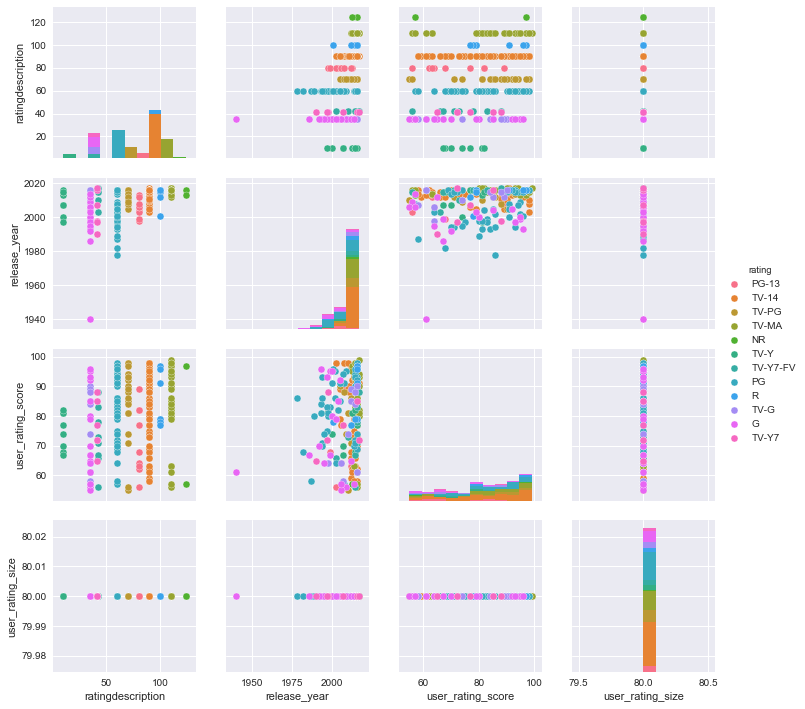

In [4]:
# Drop rows with missing values and drop duplicate
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Visualize pairplot of df
sns.pairplot(df, hue='rating');

Check out, for example, *user_rating_score* as a function of *release_year*. There is *not* a visually identifiable trend but perhaps some data analysis will draw out any trends. If you'd like to check out several summary statistics of the DataFrame, you can also do this using the `.describe()` method:

In [5]:
# Get summary stats of df
df.describe()

,ratingdescription,release_year,user_rating_score,user_rating_size
count,246.000000,246.000000,246.000000,246.0
mean,73.556911,2010.272358,81.390244,80.0
std,26.616145,8.887219,12.677883,0.0
min,10.000000,1940.000000,55.000000,80.0
25%,60.000000,2007.000000,71.000000,80.0
50%,80.000000,2015.000000,83.500000,80.0
75%,90.000000,2016.000000,92.750000,80.0
max,124.000000,2017.000000,99.000000,80.0


## Groupbys and split-apply-combine to answer the question

<a id='step_1'></a>

### Step 1. Split

Now that you've checked out out data, it's time for the fun part. You'll first use a *groupby* method to split the data into groups, where each group is the set of movies released in a given year. This is the *split* in split-apply-combine: 

In [6]:
# Group by year
df_by_year = df.groupby('release_year')

This creates a *groupby* object:

In [7]:
# Check type of GroupBy object
type(df_by_year)

pandas.core.groupby.DataFrameGroupBy

<a id='step_2'></a>

### Step 2. Apply

Such *groupby* objects are very useful. Remember that the `.describe()` method for a DataFrame returns summary statistics for numeric columns? Well, the `.describe()` method for `DataFrameGroupBy` objects returns summary statistics for each numeric column, but computed for each group in the split. In your case, it's for each *release_year*. This is an example of the *apply* in split-apply-combine: you're *applying* the `.describe()` method to each group in the *groupby*. Do this and print the first 5 rows of the result:

In [8]:
# Summary stats over years
df_by_year.describe().head()

ratingdescription                                          \
                         count  mean std   min   25%   50%   75%   max   
release_year                                                             
1940                       1.0  35.0 NaN  35.0  35.0  35.0  35.0  35.0   
1978                       1.0  60.0 NaN  60.0  60.0  60.0  60.0  60.0   
1982                       1.0  60.0 NaN  60.0  60.0  60.0  60.0  60.0   
1986                       1.0  35.0 NaN  35.0  35.0  35.0  35.0  35.0   
1987                       1.0  60.0 NaN  60.0  60.0  60.0  60.0  60.0   

             user_rating_score        ...              user_rating_size        \
                         count  mean  ...    75%   max            count  mean   
release_year                          ...                                       
1940                       1.0  61.0  ...   61.0  61.0              1.0  80.0   
1978                       1.0  86.0  ...   86.0  86.0              1.0  80.0   
1982                       1.0  68.0  ...   68.0  68.0              1.0  80.0   
1986                       1.0  67.0  ...   67.0  67.0              1.0  80.0   
1987                       1.0  58.0  ...   58.0  58.0              1.0  80.0   

                                                
             std   min   25%   50%   75%   max  
release_year                                    
1940         NaN  80.0  80.0  80.0  80.0  80.0  
1978         NaN  80.0  80.0  80.0  80.0  80.0  
1982         NaN  80.0  80.0  80.0  80.0  80.0  
1986         NaN  80.0  80.0  80.0  80.0  80.0  
1987         NaN  80.0  80.0  80.0  80.0  80.0  

[5 rows x 24 columns]

If you want to see what the grouping looks like, you can pass the _groupby_ object to the function `list()`:

In [9]:
# Cast grouping as a list and check out one year
list(df_by_year)[10]

(1995,             title rating                                ratinglevel  \
 766         Balto      G  General Audiences. Suitable for all ages.   
 967  Heavyweights     PG              some rude language and pranks   
 
      ratingdescription  release_year  user_rating_score  user_rating_size  
 766                 35          1995               64.0                80  
 967                 60          1995               74.0                80  )

<a id='step_3'></a>

### Step 3. Combine

Let's say that you wanted the mean or median *user_rating_score* for each year. Then you can apply the `.mean()` or `.median()` method, respectively, to the *groupby* object and 'combine' these into a new DataFrame.

In [10]:
# Get median values by year and print first 5 rows
df_med_by_year = df_by_year.median()
df_med_by_year.head()

,ratingdescription,user_rating_score,user_rating_size
release_year,,,
1940,35.0,61.0,80.0
1978,60.0,86.0,80.0
1982,60.0,68.0,80.0
1986,35.0,67.0,80.0
1987,60.0,58.0,80.0


There's an important subtlety concerning the index of the DataFrame `df_med_by_year`. Recall that the index of a DataFrame consists of the row labels. Check out the index of the original DataFrame `df`:

In [11]:
# Print index of df
print(df.index)

Int64Index([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            908, 911, 917, 931, 962, 966, 967, 972, 973, 979],
           dtype='int64', length=246)


This index consists of  the original row numbers, labelled by integers. '1' is missing as you dropped some rows above. The index of `df_med_by_year` consists of the values in the original column that you grouped by, the years from *release_year*:

In [12]:
# Print index
print(df_med_by_year.index)

Int64Index([1940, 1978, 1982, 1986, 1987, 1989, 1990, 1992, 1993, 1994, 1995,
            1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
            2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
           dtype='int64', name='release_year')


You're interested in the *user_rating_score* column, which contains the median rating for each year. You can slice out the *user_rating_score* column of `df_med_by_year`  and plot it as a function of the year (given by the index of the DataFrame `df_rat_by_year`):

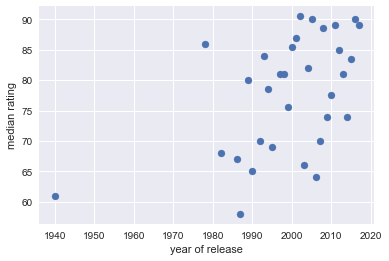

In [13]:
# Slice out user rating and plot
df_rat_by_year = df_med_by_year['user_rating_score']
plt.scatter(df_rat_by_year.index, df_rat_by_year)
plt.xlabel('year of release')
plt.ylabel('median rating');

Looking at the figure, the median rating definitely increases over time. You'd need to leverage some more sophisticated statistics to convince me of the trend in general but this an example of Exploratory Data Analysis being a great starting point for further research. 

## Groupbys and split-apply-combine in daily use

*Groupby* objects are not intuitive. They do, however, correspond to a natural the act of splitting a dataset with respect to one its columns (or more than one, but let's save that for another post about grouping by multiple columns and hierarchical indexes).

The split-apply-combine principle is not only elegant and practical, it's something that Data Scientists use daily, as in the above example. To appreciate more of its uses, check out Hadley Wickham's original [paper](https://www.jstatsoft.org/article/view/v040i01) *The Split-Apply-Combine Strategy for Data Analysis*. If you have any thoughts, responses and/or ruminations, feel free to reach out to me on twitter: [@hugobowne](https://twitter.com/hugobowne).